In [1]:
from tqdm import tqdm
import string

from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.
tokenizer = TweetTokenizer()


import warnings
warnings.filterwarnings('ignore')

import re
tqdm.pandas(desc="progress-bar")
import spacy
nlp = spacy.load('en')

In [2]:
import pandas as pd
df = pd.read_csv('final_data.csv')
df.shape

(93170, 13)

In [3]:
df = df[pd.notnull(df['Tweet'])]

In [4]:
from sklearn.utils import shuffle
df = shuffle(df)

In [5]:
col = ['Category', 'Tweet']
df = df[col]

In [6]:
df.columns = ['Category', 'Tweet']

In [7]:
def clean_text_round1(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [8]:
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical 
    text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

In [9]:
from generator import*
from cleaner import *

data_xml=[]

stop_words = ['ourselves', 'hers', 'between', 'yourself', 
              'but', 'again', 'there', 'about', 'once', 
              'during', 'out', 'very', 'with', 'they',
              'own', 'an', 'be', 'some', 'for', 'do', 'its', 
              'yours', 'such', 'into', 'of', 'most', 'itself',
              'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 
              'from', 'him', 'each', 'the', 'themselves', 'until', 
              'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don',
              'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 
              'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 
              'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 
              'been', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because',
              'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you',
              'herself', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after',
              'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 
              'how', 'further', 'was', 'here', 'than']

def tokenize(tweet):
    tweet = nlp(tweet)
    tweet = negation_tag(tweet)
    tweet = ' '.join(tweet)
    tweet = clean_text_round1(tweet)
    tweet = clean_text_round2(tweet)
    tokens = tokenizer.tokenize(tweet.lower())
    tokens = [w for w in tokens if not w in stop_words]
    
    try:
        temp=[]
        tokens = list(filter(lambda t: not t.startswith('@'), tokens))
        tokens = list(filter(lambda t: not t.startswith('#'), tokens))
        tokens = list(filter(lambda t: not t.startswith('http'), tokens))
        tokens = list(filter(lambda t: not t.startswith('www'), tokens))
        temp.append(tokens)
        data_xml.append(temp)
        

        return tokens
    except:
        return 'NC'

In [10]:
def postprocess(data, n=3000):
    data = data.head(n)
    data['tokens'] = data['Tweet'].progress_map(tokenize) 
    data = data[data.tokens != 'NC']
    data.reset_index(inplace=True)
    return data

data = postprocess(df)

progress-bar: 100%|██████████| 3000/3000 [00:32<00:00, 91.07it/s] 


In [11]:
data.shape

(3000, 4)

### Construction des mots embarqués

In [12]:
from sklearn.model_selection import train_test_split
import numpy as np

In [13]:
x_train, x_test, y_train, y_test = train_test_split(np.array(data.head(93170).tokens),
                                   np.array(data.head(93170).Tweet), test_size=0.2)

In [14]:
import gensim
from gensim.models.word2vec import Word2Vec 
LabeledSentence = gensim.models.doc2vec.LabeledSentence

In [15]:
def labelizeTweets(tweets, label_type):
    labelized = []
    for i,v in tqdm(enumerate(tweets)):
        label = '%s_%s'%(label_type,i)
        labelized.append(LabeledSentence(v, [label]))
    return labelized

x_train = labelizeTweets(x_train, 'TRAIN')
x_test = labelizeTweets(x_test, 'TEST')

2400it [00:00, 185873.10it/s]
600it [00:00, 175481.65it/s]


In [16]:
tweet_w2v = Word2Vec(size=150, min_count=20,sg=0)#sg=1: skip-gram, 0: cbow
tweet_w2v.build_vocab([x.words for x in tqdm(x_train)])
tweet_w2v.train([x.words for x in tqdm(x_train)], 
                total_examples=tweet_w2v.corpus_count, epochs=tweet_w2v.iter)

100%|██████████| 2400/2400 [00:00<00:00, 1656463.65it/s]


(22589, 101710)

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from sklearn.decomposition import PCA

def plot_words(words):
    word_vecs = [tweet_w2v[word] for word in words]
    pca = PCA(n_components=2)

    columns = ["Component1","Component2"]
    df = pd.DataFrame(pca.fit_transform(word_vecs), columns=columns, index=words)
    def annotate_df(row):  
        ax.annotate(row.name, list(row.values),
                    xytext=(10,-5), 
                    textcoords='offset points',
                    size=12, 
                    color='black')

    ax = df.plot(kind="scatter",x='Component1', y='Component2',)
    _ = df.apply(annotate_df, axis=1)
    plt.savefig('outputcb.jpg')

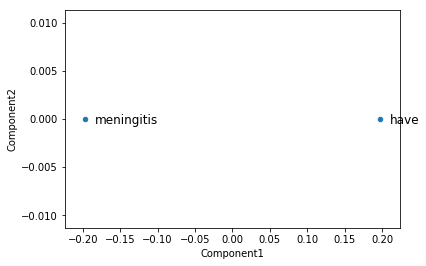

In [18]:
words=['meningitis', 'have']

plot_words(words)

## Transformation des Tweet en Espace Vectoriel

In [19]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
print('building tf-idf matrix ...')
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=0)
matrix = vectorizer.fit_transform([x.words for x in x_train])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print('vocab size :', len(tfidf))

building tf-idf matrix ...
vocab size : 3899


In [21]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += tweet_w2v[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [66]:
from sklearn.preprocessing import scale
vectors = np.concatenate([buildWordVector(z, 150) for z in tqdm(map(lambda x: x, data.Tweet))])
labels=[label for label in  data.Category]
vectors = scale(vectors)

3000it [00:00, 3496.70it/s]


In [67]:
data.shape

(3000, 5)

## ANN

In [68]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, data.index, test_size=0.33, random_state=0)

In [69]:
X_train[1000]

array([ 0.41277889,  0.34422261,  0.36083267, -0.58695572,  0.48923418,
       -0.36438337, -0.349261  ,  0.36087903,  0.51488842, -0.53379107,
       -0.25386684,  0.26752218,  0.49653949, -0.4017896 , -0.3700705 ,
        0.2563091 , -0.34121958, -0.33943871,  0.34738613, -0.443289  ,
       -0.39349764, -0.68312575,  0.42407091,  0.50503986, -0.35344771,
       -0.38757253, -0.34055797, -0.52192214, -0.57995805,  0.31031338,
       -0.4414501 , -0.28565697, -0.39193334,  0.36410287,  0.37683747,
       -0.36089059,  0.39220542, -0.4033181 ,  0.35880392, -0.59273505,
       -0.27102057, -0.33559202, -0.25140444, -0.36107128,  0.37329036,
       -0.31058309,  0.35154163,  0.49388114,  0.36319639, -0.34290379,
        0.71200503,  0.37146819,  0.32402328,  0.33641976,  0.57315778,
        0.36278683, -0.37579469,  0.35721774, -0.30626218, -0.56638955,
        0.348664  , -0.3932762 ,  0.35978572, -0.29157795,  0.45960481,
        1.24661809,  0.44929339,  0.31736431,  0.06164442, -0.04

In [70]:
from sklearn import preprocessing
encoder = preprocessing.LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

### Keras

In [71]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [72]:
model= Sequential()

In [73]:
model.add(Dense(512, input_shape=(150,)))
model.add(Activation('relu'))

In [74]:
model.add(Dense(5))
model.add(Activation('softmax'))

In [75]:
model.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])

In [76]:
history = model.fit(X_train, y_train, 
                    batch_size=100, 
                    epochs=150, 
                    verbose=1, 
                    validation_split=0.1)

Train on 1809 samples, validate on 201 samples
Epoch 1/150
1809/1809 [==============================] - 0s 129us/step - loss: 1.4097 - acc: 0.4959 - val_loss: 1.0142 - val_acc: 0.6468
Epoch 2/150
1809/1809 [==============================] - 0s 23us/step - loss: 0.9446 - acc: 0.6810 - val_loss: 0.9856 - val_acc: 0.6269
Epoch 3/150
1809/1809 [==============================] - 0s 26us/step - loss: 0.7645 - acc: 0.7496 - val_loss: 1.3660 - val_acc: 0.5920
Epoch 4/150
1809/1809 [==============================] - 0s 24us/step - loss: 0.7067 - acc: 0.7717 - val_loss: 0.8313 - val_acc: 0.7313
Epoch 5/150
1809/1809 [==============================] - 0s 24us/step - loss: 0.6225 - acc: 0.7888 - val_loss: 0.7677 - val_acc: 0.7264
Epoch 6/150
1809/1809 [==============================] - 0s 25us/step - loss: 0.5285 - acc: 0.8253 - val_loss: 0.6967 - val_acc: 0.7662
Epoch 7/150
1809/1809 [==============================] - 0s 24us/step - loss: 0.4994 - acc: 0.8463 - val_loss: 0.5149 - val_acc: 0.8259


1809/1809 [==============================] - 0s 25us/step - loss: 0.1139 - acc: 0.9630 - val_loss: 0.2718 - val_acc: 0.9303
Epoch 61/150
1809/1809 [==============================] - 0s 24us/step - loss: 0.1473 - acc: 0.9569 - val_loss: 0.2517 - val_acc: 0.9204
Epoch 62/150
1809/1809 [==============================] - 0s 25us/step - loss: 0.1328 - acc: 0.9585 - val_loss: 0.2826 - val_acc: 0.9154
Epoch 63/150
1809/1809 [==============================] - 0s 24us/step - loss: 0.1078 - acc: 0.9635 - val_loss: 0.3301 - val_acc: 0.9204
Epoch 64/150
1809/1809 [==============================] - 0s 22us/step - loss: 0.1222 - acc: 0.9585 - val_loss: 0.2414 - val_acc: 0.9303
Epoch 65/150
1809/1809 [==============================] - 0s 22us/step - loss: 0.1622 - acc: 0.9464 - val_loss: 0.2581 - val_acc: 0.9353
Epoch 66/150
1809/1809 [==============================] - 0s 22us/step - loss: 0.0969 - acc: 0.9679 - val_loss: 0.2501 - val_acc: 0.9254
Epoch 67/150
1809/1809 [==============================

Epoch 120/150
1809/1809 [==============================] - 0s 23us/step - loss: 0.0625 - acc: 0.9867 - val_loss: 0.3203 - val_acc: 0.9154
Epoch 121/150
1809/1809 [==============================] - 0s 20us/step - loss: 0.1319 - acc: 0.9657 - val_loss: 0.3470 - val_acc: 0.8955
Epoch 122/150
1809/1809 [==============================] - 0s 20us/step - loss: 0.0689 - acc: 0.9818 - val_loss: 0.3189 - val_acc: 0.9403
Epoch 123/150
1809/1809 [==============================] - 0s 22us/step - loss: 0.0792 - acc: 0.9779 - val_loss: 0.2858 - val_acc: 0.9303
Epoch 124/150
1809/1809 [==============================] - 0s 21us/step - loss: 0.1076 - acc: 0.9751 - val_loss: 0.3606 - val_acc: 0.9055
Epoch 125/150
1809/1809 [==============================] - 0s 22us/step - loss: 0.0571 - acc: 0.9840 - val_loss: 0.3414 - val_acc: 0.9254
Epoch 126/150
1809/1809 [==============================] - 0s 24us/step - loss: 0.0840 - acc: 0.9784 - val_loss: 0.2832 - val_acc: 0.9303
Epoch 127/150
1809/1809 [=========

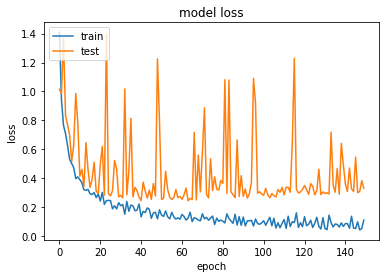

In [77]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy.jpg',  bbox_inches = "tight")
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Faire de la prediction

In [78]:
labels[1]

'Vaccine'

In [79]:
for i in range(10):    
    prediction = model.predict(np.array([X_test[i]]))
    print(prediction)

[[4.9866069e-02 1.1915878e-08 2.1690397e-02 6.1556087e-11 9.2844355e-01]]
[[2.7744114e-05 4.4761929e-13 8.9270330e-04 3.5722139e-01 6.4185822e-01]]
[[1.9527560e-09 7.6715345e-16 1.3046007e-12 9.9995387e-01 4.6172594e-05]]
[[6.2156930e-10 8.6429774e-10 3.4603152e-05 9.6433418e-05 9.9986899e-01]]
[[2.4323226e-08 3.1119776e-09 2.3650859e-06 9.9028858e-13 9.9999762e-01]]
[[3.1236000e-10 6.6307709e-03 9.9333787e-01 1.2768990e-07 3.1299383e-05]]
[[6.3014394e-09 1.7682406e-11 3.2425260e-10 9.9999666e-01 3.3065678e-06]]
[[9.8054129e-01 9.4190220e-09 1.7683901e-02 4.9894839e-05 1.7249233e-03]]
[[7.3015025e-07 4.2884787e-14 2.4326886e-11 9.9999511e-01 4.1755402e-06]]
[[1.9903629e-10 3.5869802e-20 2.0526262e-15 1.0000000e+00 3.3293323e-12]]


In [80]:
labels[0]

'Vaccine'

In [90]:
i=3
text_labels = encoder.classes_ 
predicted_label = labels[np.argmax(prediction[0])]

print(data.Tweet.iloc[i], "...")
print("===========================================================")
print('Actual label:' + str(labels[i]))
print("Predicted label: " + predicted_label)

really going get meningitis dont get ...
Actual label:Infection
Predicted label: Infection


## Reglage des paramètres

In [91]:
def create_model(optimizer='adam', activation='relu'):
   # create model
    model = Sequential()
    model.add(Dense(512, input_shape=(150,), activation=activation))
    model.add(Dense(5, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [93]:
model = KerasClassifier(build_fn=create_model, verbose=0)
batch_size = [10, 20, 40]
epochs = [10, 50, 150]

optimizer = ['Adam', 'Adamax', 'Nadam']

activation = ['softmax', 'relu', 'tanh']

param_grid = dict(optimizer=optimizer, batch_size=batch_size, nb_epoch=epochs, activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.835821 using {'activation': 'tanh', 'batch_size': 10, 'nb_epoch': 10, 'optimizer': 'Adam'}
0.413433 (0.053078) with: {'activation': 'softmax', 'batch_size': 10, 'nb_epoch': 10, 'optimizer': 'Adam'}
0.388060 (0.028502) with: {'activation': 'softmax', 'batch_size': 10, 'nb_epoch': 10, 'optimizer': 'Adamax'}
0.522886 (0.025861) with: {'activation': 'softmax', 'batch_size': 10, 'nb_epoch': 10, 'optimizer': 'Nadam'}
0.414925 (0.045287) with: {'activation': 'softmax', 'batch_size': 10, 'nb_epoch': 50, 'optimizer': 'Adam'}
0.416915 (0.061034) with: {'activation': 'softmax', 'batch_size': 10, 'nb_epoch': 50, 'optimizer': 'Adamax'}
0.480597 (0.056912) with: {'activation': 'softmax', 'batch_size': 10, 'nb_epoch': 50, 'optimizer': 'Nadam'}
0.416915 (0.051101) with: {'activation': 'softmax', 'batch_size': 10, 'nb_epoch': 150, 'optimizer': 'Adam'}
0.417413 (0.055127) with: {'activation': 'softmax', 'batch_size': 10, 'nb_epoch': 150, 'optimizer': 'Adamax'}
0.461692 (0.005074) with: {'activat